In [15]:
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.datasets import make_moons, make_blobs, make_classification
from sklearn.manifold import TSNE
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import pdist, squareform
from lund.lund import LearningbyUnsupervisedNonlinearDiffusion
from lund.utils import GraphExtractor, diffusion_distance
from model.utils import loadHSI,calculate_aligned_accuracy
import matplotlib.pyplot as plt
import scipy.io
from sklearn.cluster import SpectralClustering
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment


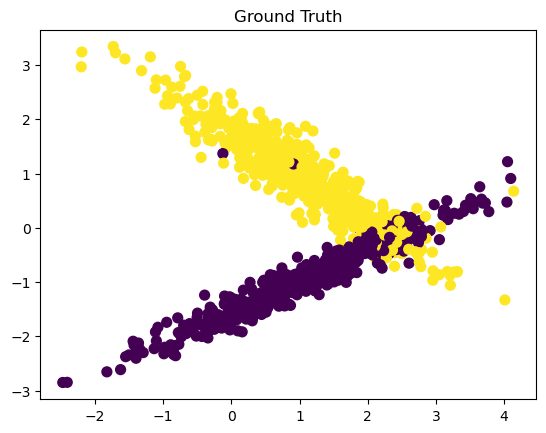

In [16]:
X, GT = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()
    
plot_clusters(X, GT, "Ground Truth")

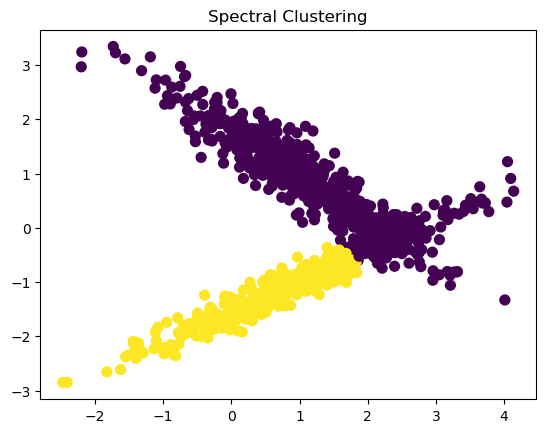

In [17]:
C = SpectralClustering(n_clusters=2,
        assign_labels='discretize', affinity='nearest_neighbors',
        random_state=42).fit(X)

plot_clusters(X, C.labels_, title = "Spectral Clustering")

In [18]:
# accuracy
def calculate_aligned_accuracy(ground_truth, cluster_labels):
    true_labels = ground_truth.flatten()
    cm = confusion_matrix(true_labels, cluster_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)
    label_mapping = {col_ind[i]: row_ind[i] for i in range(len(row_ind))}
    aligned_labels = np.array([label_mapping[label] for label in cluster_labels])

    accuracy = np.mean(aligned_labels == true_labels)

    return accuracy

In [19]:
accuracy = calculate_aligned_accuracy(GT, C.labels_)
print("Aligned Accuracy:", accuracy)

Aligned Accuracy: 0.865
